# NDReg

## Preface
I am completing this algorithms MD to the extent of my current knowledge. I will be meeting with Kwame on Tuesday 1/17 in order to fill in the gaps in my knowledge and obtain a more comprehensive understanding of the algorithm. 

## Algorithm
### Description
NDReg is an algorithm designed to calculate one or more coordinate transformations with the goal of aligning two images of the same scene. For our specific application, NDreg will be used to track specific synapses over time, such that stochastic statistics can be generated about the subject's synaptic activity.

### Inputs
- inImg_ds -> The image two be aligned
- refImage_ds -> The image which inImg_ds is being aligned to
- iterations -> The number of iterations to run the algorithm
- useMI -> Whether or not to use MI (Mutual Information)
- verbose -> Whether or not to print progress and debug data

### Outputs
- The parameters of an affine transform that maps the inImg_ds to the refImage_ds

### Function

In [3]:
####################################################
###PSEUDOCODE WILL GO HERE ONCE I MEET WITH KWAME###
####################################################

### Analysis
#### Qualitative Visualizations
I will display the input and base image to be passed to the register function, and the result of applying the register function's output to the input image.

#### Quantitative Score
I will use the following loss function (sum of squared errors) to evaluate the success of the algorithm:
$\Sigma_{voxels}L_2(inputImage[voxel] - baseImage[voxel])$

#### Summary Score
I will use the average percent reduction in squared error over a series of tests to summarize the quantitative performance of the algorithm.

#### Null Comparison
I will compare the results of the register function to a function which generates and applies a random rigid body transformation in order to demonstrate how well the algorithm performes compared to random guessing.



### Write Code

In [4]:
import sys
sys.path.insert(0, '../../../ndreg/')
import ndreg

def register(inImg, baseImg):
    return ndreg.imgAffineComposite(inImg,
                              baseImg,
                              iterations=200,
                              useMI=True,
                              verbose=False)

## Simulation
### Functionality Testing
NDReg functionality tests will be performed in order to verify that the register funciton is working as expected.

#### 1. Generate Data

In [5]:
refImg = ndreg.imgDownload('ara_ccf2')
refAnnoImg = ndreg.imgDownload('ara_ccf2', channel="annotation")
inImg = ndreg.imgDownload('eacker01', 'r', 5)

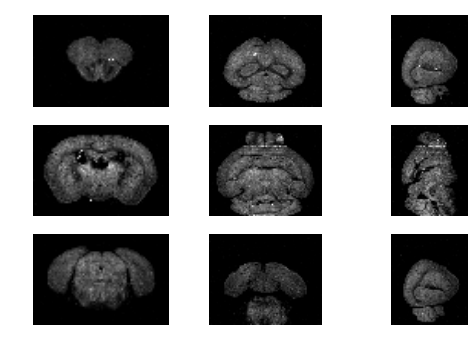

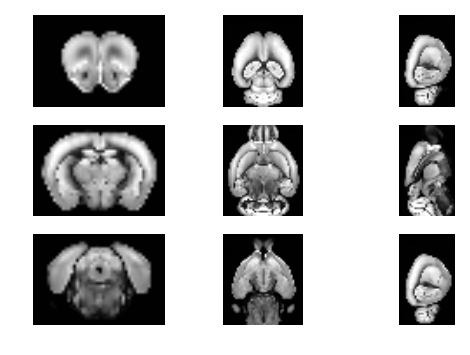

In [6]:
#reorient and rescale the test image
inImgReor = ndreg.imgReorient(inImg, 'lsp', 'rsa')
inImg_ds = ndreg.imgResample(inImgReor, spacing=[.25, .25, .25])
refImg_ds = ndreg.imgResample(refImg, spacing=[.25, .25, .25])

#display the images to be registered
ndreg.imgShow(inImg_ds, vmax=10000)
ndreg.imgShow(refImg_ds, vmax=500)

#### 2. Generate Results

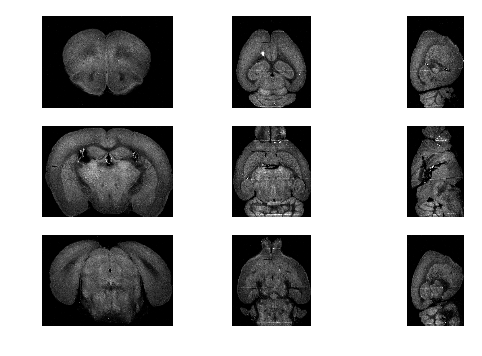

In [7]:
affine = register(inImg_ds, refImg_ds)
resultImage = ndreg.imgApplyAffine(inImgReor,
                                   affine,
                                   size=refImg.GetSize(),
                                   spacing=refImg.GetSpacing())
ndreg.imgShow(resultImage, vmax=10000)

#### 3. Analyze Results
The results of this functionality test are consistent with those of the NDReg documentation. I can now proceed to the validation testing phase. 

### Validation Testing
#### 1. Generate Data
The following code will generate two 100x100x100 volumes randomly populated with synapses and noise modeling that of the real world data, and then apply a random affine transformation to one of the volumes. The volumes will then be run thorugh the register algorithm in order to attemt to align them again.

In [47]:
import math
import numpy as np
import SimpleITK as itk
from random import randrange as rand
from random import uniform as floatRand
from affine import Affine

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)               
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                        
                if valid:
                    toPopulate.append(curPoint)
            
    return set(toPopulate)                       
   
def getTransform():
    #generate a random rigid body transform
    #error is assumed to be 5% rotationally
    #and laterally
    a = floatRand(-.075, .075)
    b = floatRand(-.075, .075)
    c = floatRand(-.075, .075)
    xt = floatRand(-2.5, 2.5)
    yt = floatRand(-2.5, 2.5)
    zt = floatRand(-2.5, 2.5)
    transform = np.stack([
        [math.cos(a)*math.cos(b), math.cos(a)*math.sin(b)*math.sin(c)-math.sin(a)*math.cos(c), math.cos(a)*math.sin(b)*math.cos(c)+math.sin(a)*math.sin(c), xt],
        [math.sin(a)*math.cos(b), math.sin(a)*math.sin(b)*math.sin(c)+math.cos(a)*math.cos(c), math.sin(a)*math.sin(b)*math.cos(c)-math.cos(a)*math.sin(c), yt],
        [-math.sin(b), math.cos(b)*math.sin(c), math.cos(b)*math.cos(c), zt],
        [0., 0., 0., 1.]
    ])
    return transform
    
    
def applyRigid(initialVolume, transform):
    rigidMatrix = np.zeros_like(initialVolume)    
    for z in range(initialVolume.shape[0]):
        for y in range(initialVolume.shape[1]):
            for x in range(initialVolume.shape[2]):
                new = np.dot(transform, [x, y, z, 1])
                try:
                    rigidMatrix[int(new[2])][int(new[1])][int(new[0])] = initialVolume[z][y][x]
                #if transformed place is out of bounds, dont deal with it
                except IndexError:
                        continue
    return rigidMatrix
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
      
    #convert numpy array to itk image
    itkVolume = itk.GetImageFromArray(noiseVolume)
    
    #perform a random rigid body transform to generate the second volume
    transform = getTransform()
    rigidMatrix = applyRigid(noiseVolume, transform)
    
    rigidVolume = itk.GetImageFromArray(rigidMatrix)
    return itkVolume, rigidVolume, transform

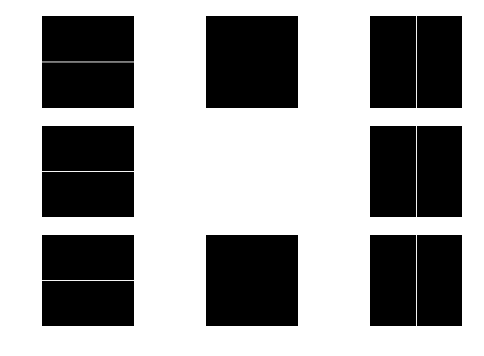

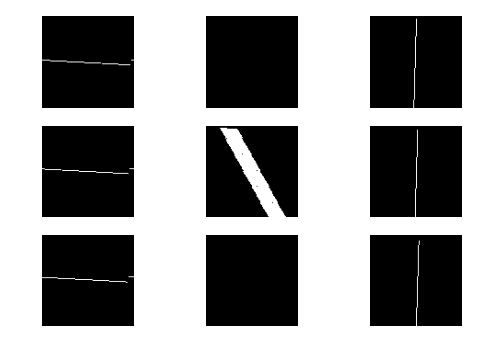

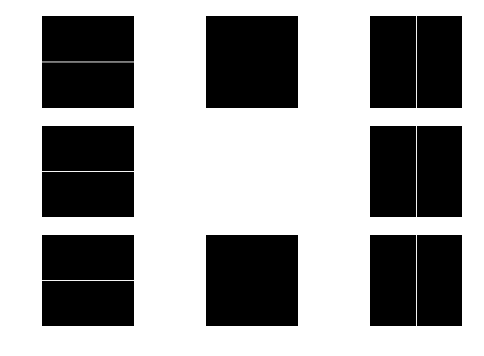

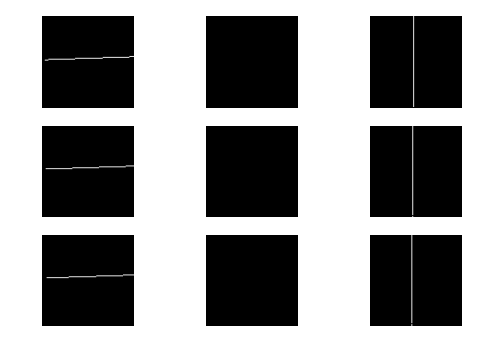

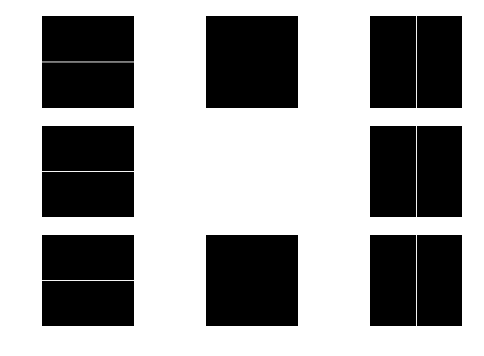

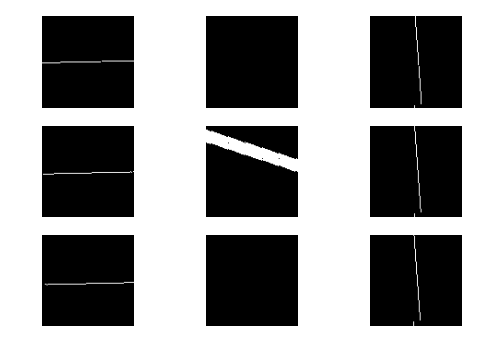

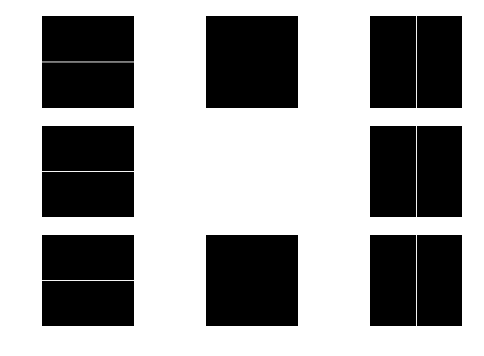

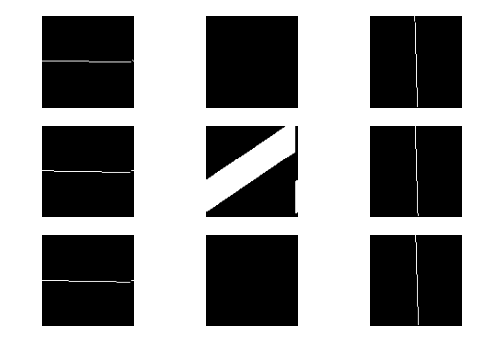

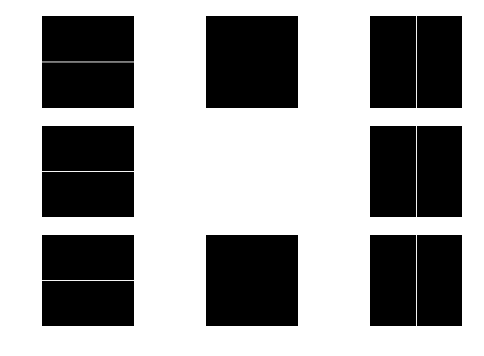

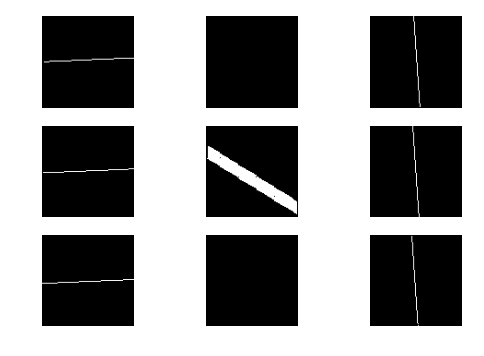

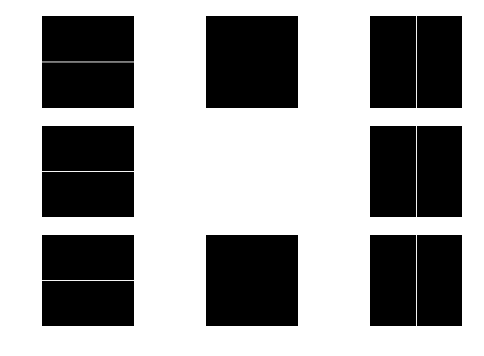

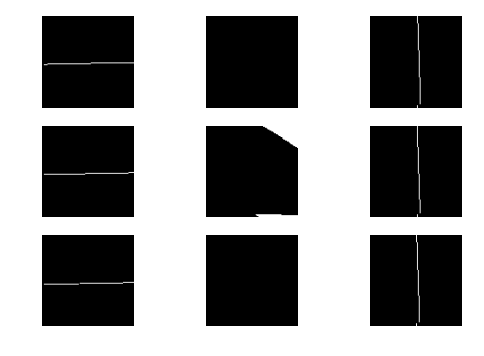

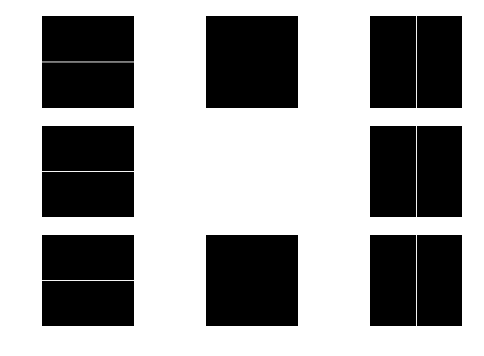

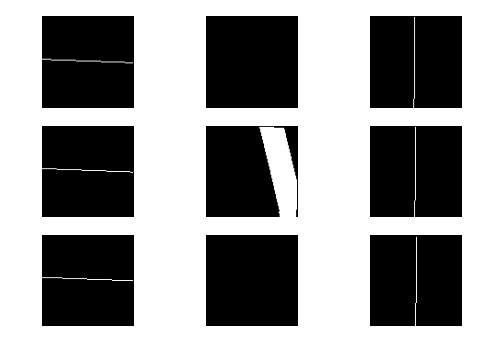

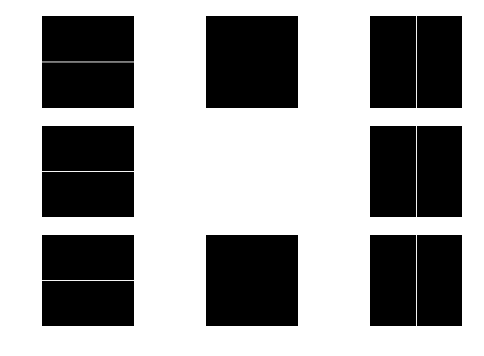

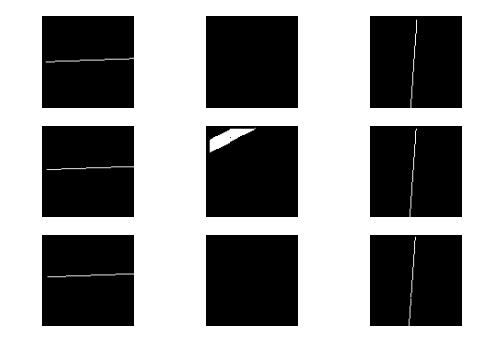

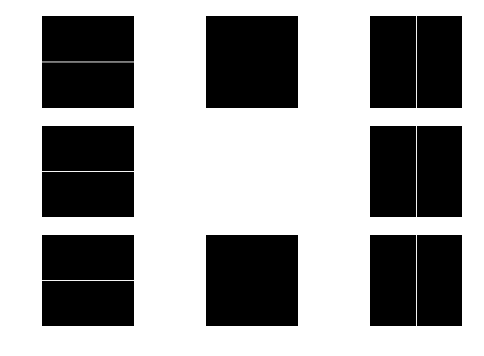

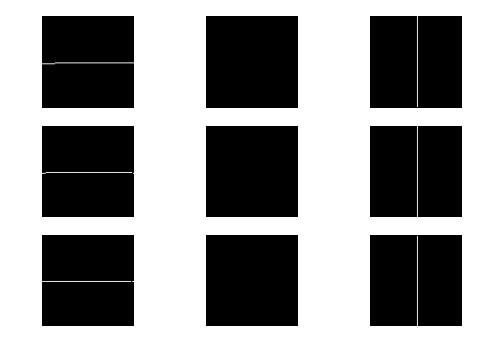

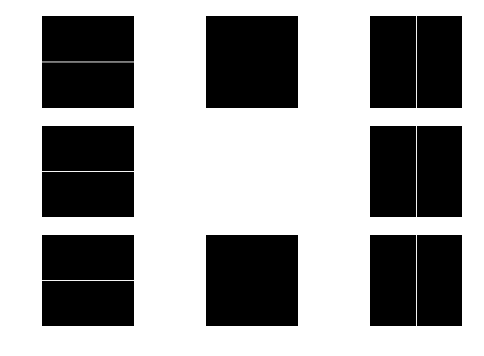

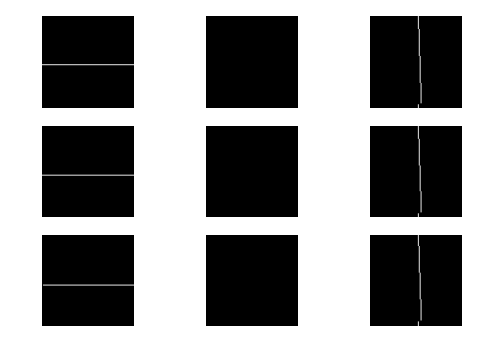

In [48]:
#a quick functionality test for the random rigid

for i in range(10):
    this = np.zeros((100, 100, 100))
    for x in range(0, 100):
        for z in range(0, 100):
            this[z][50][x] = 60000
    
    transform = getTransform()
    that = applyRigid(this, transform)   
    those = itk.GetImageFromArray(that)
    ndreg.imgShow(itk.GetImageFromArray(this), vmax=60000)
    ndreg.imgShow(those, vmax=60000)


Executing Test:  1
[[ 0.99633382 -0.04478962  0.07288901  0.65847989]
 [ 0.0468923   0.9985242  -0.02739601  1.90390603]
 [-0.07155439  0.03071351  0.99696372  0.98219157]
 [ 0.          0.          0.          1.        ]]


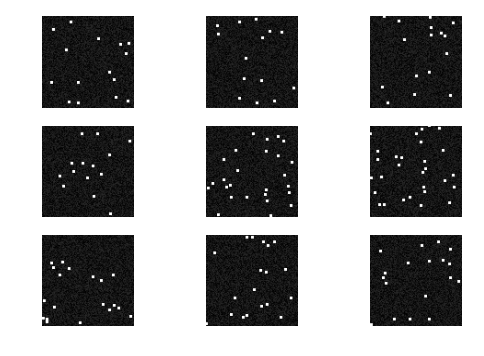

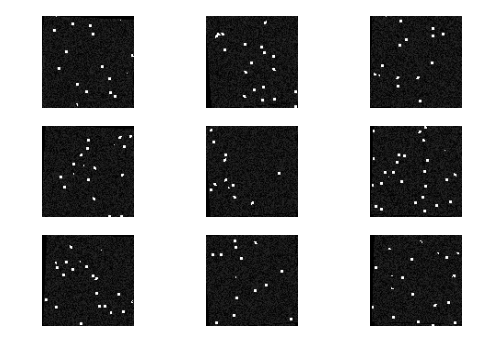

	Initial Error:  9.89482470995e+13


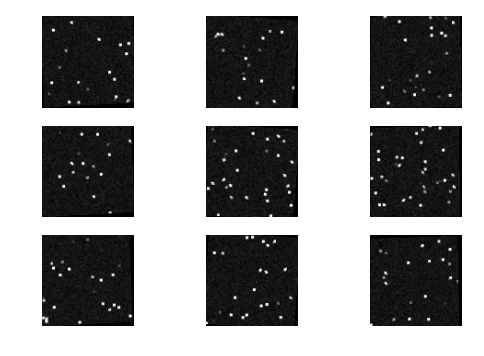

	Final Pipeline Error:  2.15551175833e+13
	Final Random Error:  9.90556338707e+13
	Pipeline Reduction Ratio:  0.782157661048
	Random Reduction Ratio:  -0.00108528219856





Executing Test:  2
[[ 0.99808651 -0.05805547  0.02128114 -1.98479023]
 [ 0.05780255  0.99825209  0.01231355 -0.93428307]
 [-0.02195881 -0.01105989  0.9996977  -1.89142933]
 [ 0.          0.          0.          1.        ]]


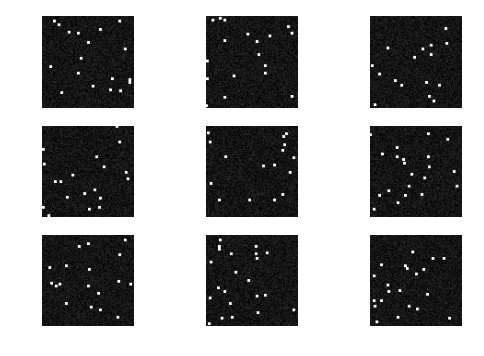

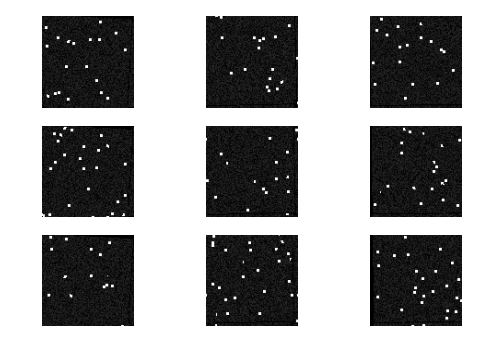

	Initial Error:  1.15185690184e+14


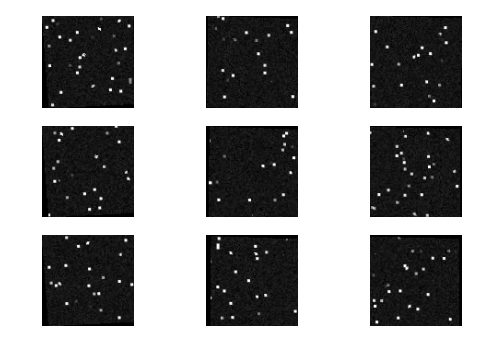

	Final Pipeline Error:  4.29550720519e+13
	Final Random Error:  1.14569602006e+14
	Pipeline Reduction Ratio:  0.627079787574
	Random Reduction Ratio:  0.00534865205118





Executing Test:  3
[[ 0.99899494 -0.04469633  0.0033696   0.61064526]
 [ 0.04443027  0.99736801  0.05729746  1.37971269]
 [-0.00592172 -0.05709016  0.99835146 -1.98646638]
 [ 0.          0.          0.          1.        ]]


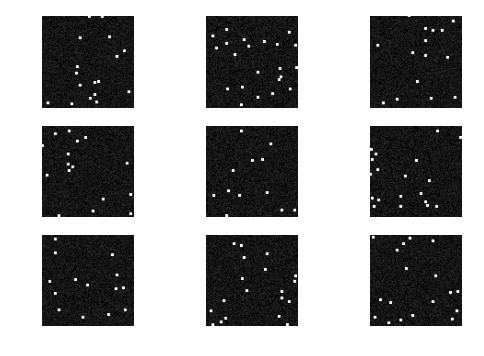

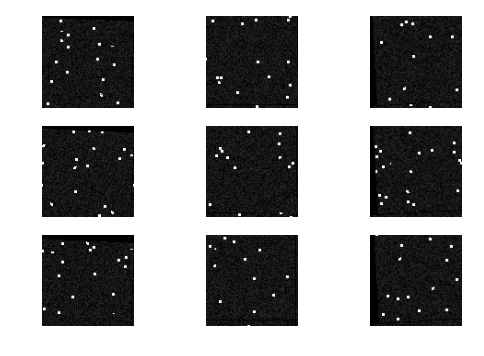

	Initial Error:  9.9570200476e+13


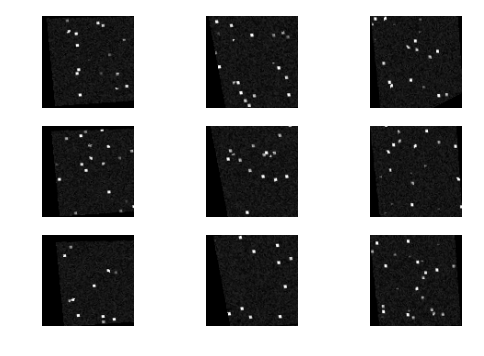

	Final Pipeline Error:  8.24781035999e+13
	Final Random Error:  9.88089745886e+13
	Pipeline Reduction Ratio:  0.171658757282
	Random Reduction Ratio:  0.00764511755293





Executing Test:  4
[[ 0.99860248  0.0334092  -0.04095017  2.43309217]
 [-0.03463821  0.99895912 -0.02967943 -0.42997747]
 [ 0.03991598  0.03105639  0.99872029  0.61432542]
 [ 0.          0.          0.          1.        ]]


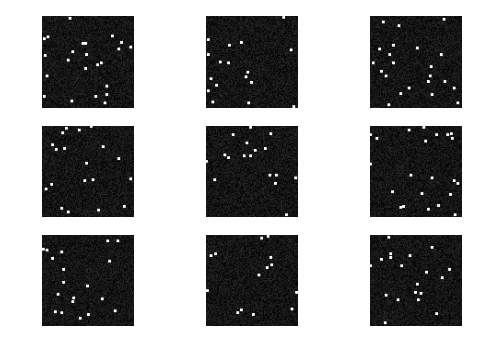

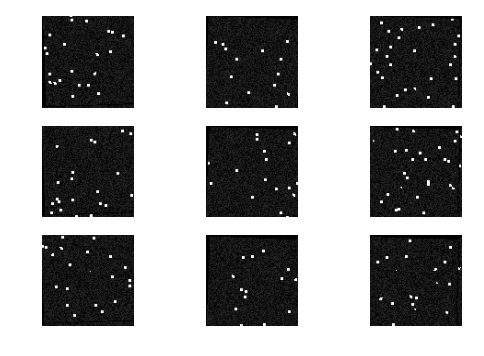

	Initial Error:  1.17321131558e+14


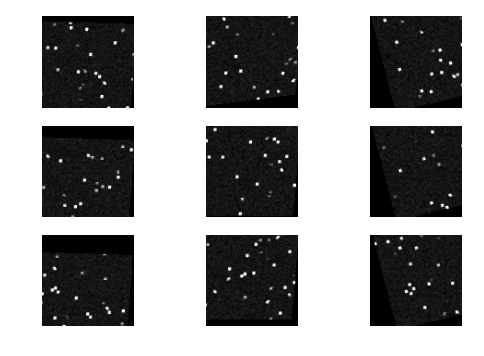

	Final Pipeline Error:  9.62785497902e+13
	Final Random Error:  1.14837695913e+14
	Pipeline Reduction Ratio:  0.179358837478
	Random Reduction Ratio:  0.021167845998





Executing Test:  5
[[ 0.99799284 -0.03717897  0.0512641   0.38309566]
 [ 0.04029438  0.99731547 -0.0611409   0.40343932]
 [-0.04885332  0.06308383  0.99681181 -1.19756343]
 [ 0.          0.          0.          1.        ]]


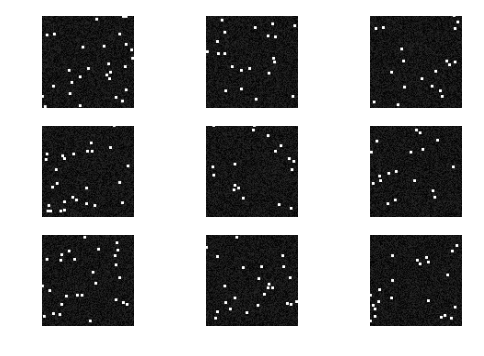

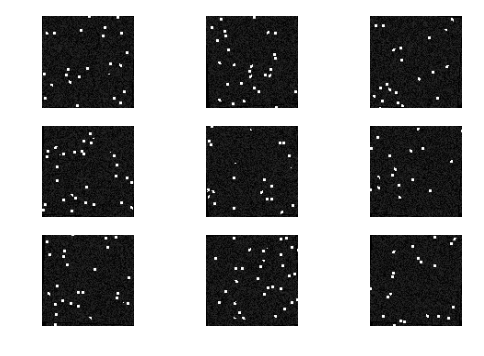

	Initial Error:  1.27137820785e+14


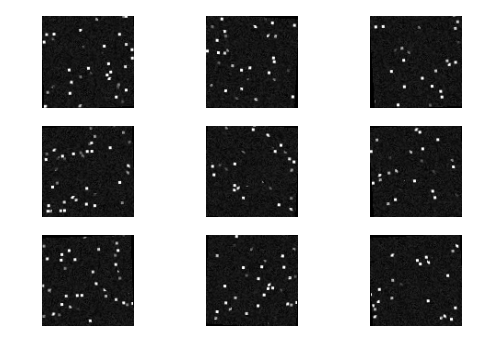

	Final Pipeline Error:  2.66237657634e+13
	Final Random Error:  1.37614643458e+14
	Pipeline Reduction Ratio:  0.790591300064
	Random Reduction Ratio:  -0.0824052402968





Executing Test:  6
[[ 0.99735889 -0.06874842 -0.02342852  2.0903296 ]
 [ 0.06958368  0.99689246  0.03692602  2.06824737]
 [ 0.02081711 -0.03845874  0.99904333  1.67298523]
 [ 0.          0.          0.          1.        ]]


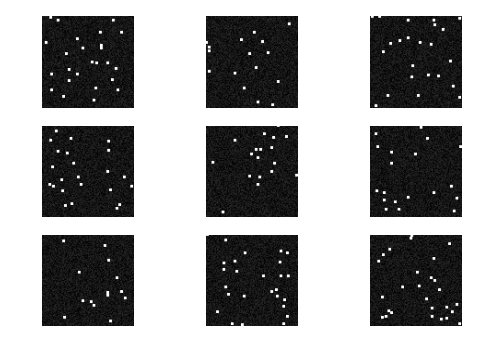

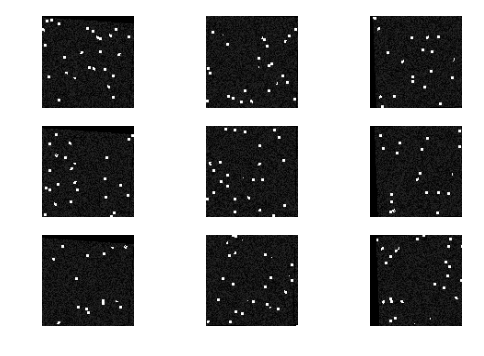

	Initial Error:  1.32388750534e+14


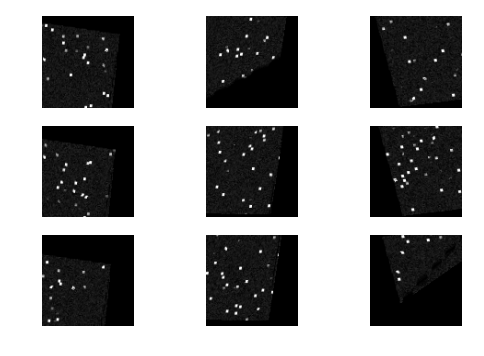

	Final Pipeline Error:  1.08375589871e+14
	Final Random Error:  1.30951694977e+14
	Pipeline Reduction Ratio:  0.181383694353
	Random Reduction Ratio:  0.0108548162239





Executing Test:  7
[[ 0.99847562 -0.03307971 -0.04418333  2.22752948]
 [ 0.03065538  0.99804506 -0.05446383 -0.13029317]
 [ 0.0458986   0.05302634  0.99753773  0.74882985]
 [ 0.          0.          0.          1.        ]]


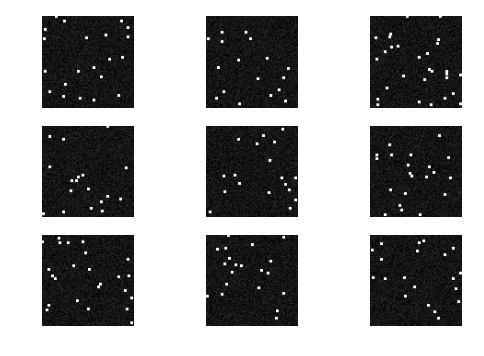

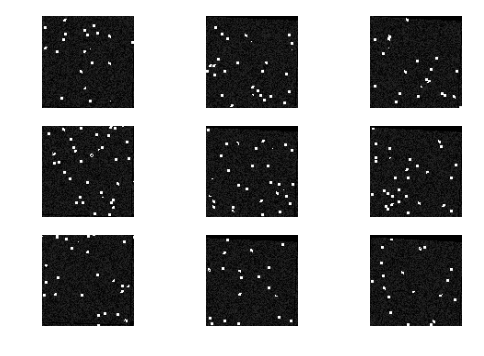

	Initial Error:  1.36462341787e+14


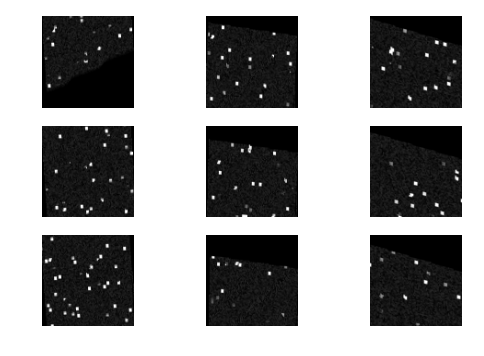

	Final Pipeline Error:  1.10249892939e+14
	Final Random Error:  1.27470226782e+14
	Pipeline Reduction Ratio:  0.192085585699
	Random Reduction Ratio:  0.0658944796648





Executing Test:  8
[[ 0.9996983   0.00383172 -0.02426147 -0.22890644]
 [-0.00353784  0.99992     0.01214432 -1.94835637]
 [ 0.02430606 -0.01205483  0.99963188  1.92701639]
 [ 0.          0.          0.          1.        ]]


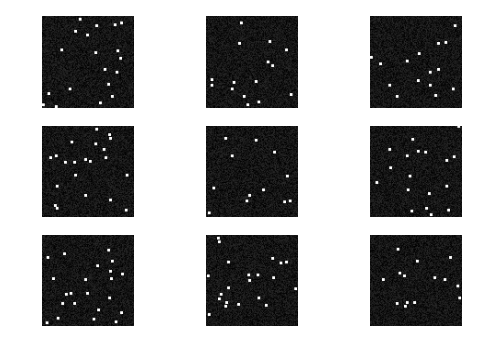

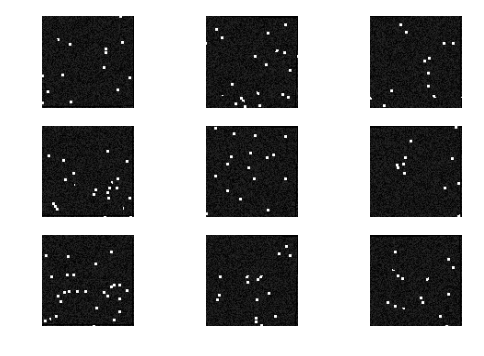

	Initial Error:  1.05880372067e+14


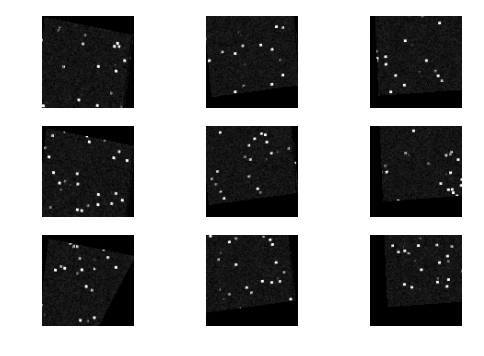

	Final Pipeline Error:  9.11192832861e+13
	Final Random Error:  1.09171266635e+14
	Pipeline Reduction Ratio:  0.139412891102
	Random Reduction Ratio:  -0.0310812523949





Executing Test:  9
[[ 0.99847754 -0.05238714  0.01726818 -1.69959855]
 [ 0.05248421  0.99860813 -0.00521667  1.12834542]
 [-0.01697086  0.00611503  0.99983728  1.87751395]
 [ 0.          0.          0.          1.        ]]


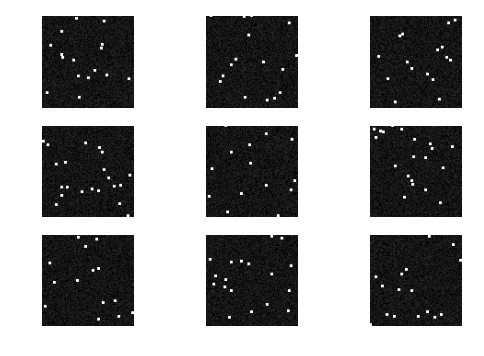

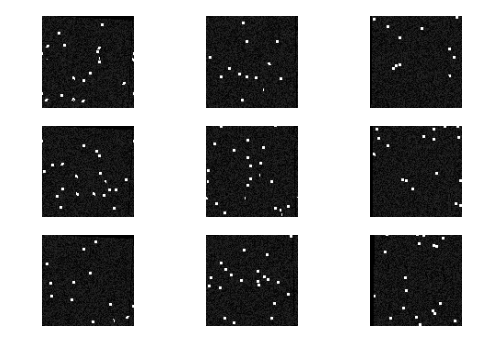

	Initial Error:  9.85415948838e+13


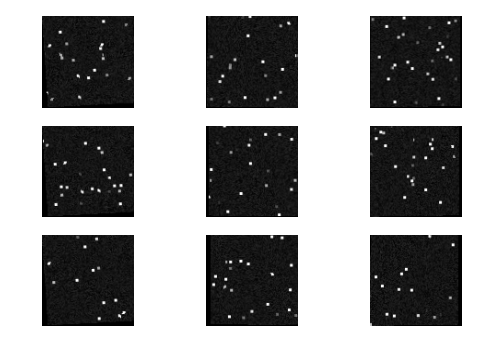

	Final Pipeline Error:  2.95110881326e+13
	Final Random Error:  9.88363365339e+13
	Pipeline Reduction Ratio:  0.70052150904
	Random Reduction Ratio:  -0.00299103795156





Executing Test:  10
[[ 0.99736043  0.07049025  0.01741519 -0.26282196]
 [-0.06950112  0.99622336 -0.05204439  2.47412612]
 [-0.02101804  0.05069664  0.99849291  1.94344905]
 [ 0.          0.          0.          1.        ]]


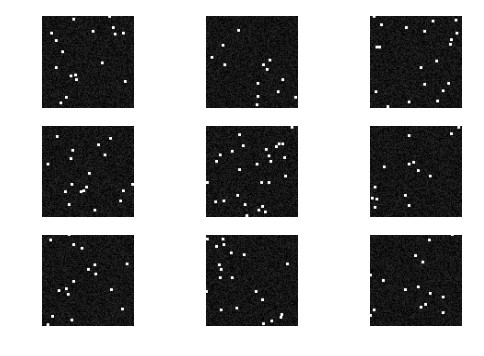

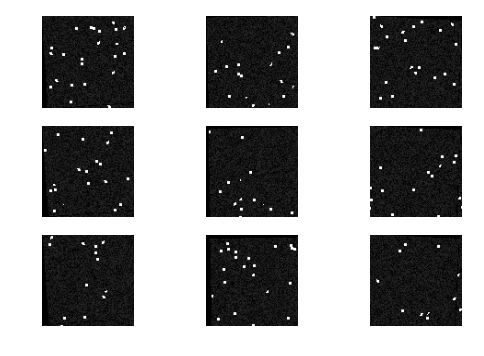

	Initial Error:  1.12730096977e+14


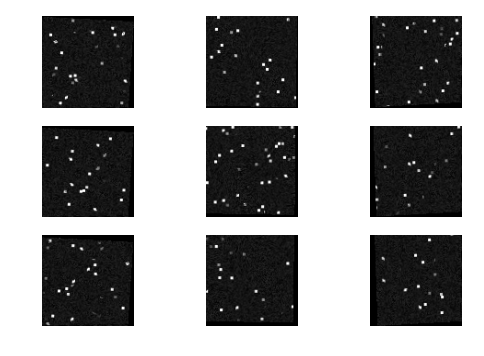

	Final Pipeline Error:  3.79479157933e+13
	Final Random Error:  1.09991153175e+14
	Pipeline Reduction Ratio:  0.663373696902
	Random Reduction Ratio:  0.0242964734017





Executing Test:  11
[[ 0.9967451  -0.04741924 -0.06519678  1.02751363]
 [ 0.05171019  0.99649308  0.06578442  0.61679358]
 [ 0.06184869 -0.06894163  0.99570166 -2.43726879]
 [ 0.          0.          0.          1.        ]]


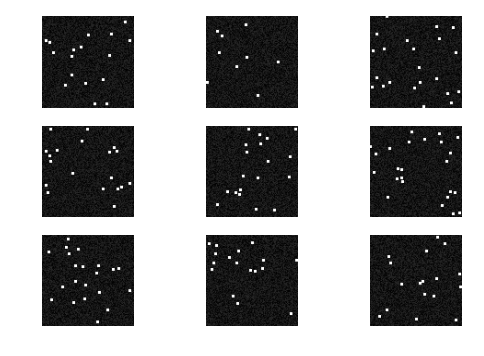

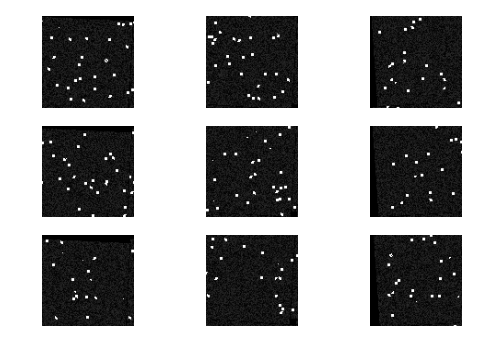

	Initial Error:  1.24538580677e+14


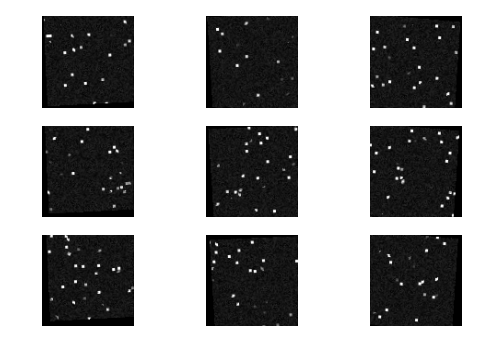

	Final Pipeline Error:  4.06217751373e+13
	Final Random Error:  1.22544739563e+14
	Pipeline Reduction Ratio:  0.673821759359
	Random Reduction Ratio:  0.0160098268647





Executing Test:  12
[[  9.99335593e-01  -3.64230777e-02   1.31611333e-03   1.48691784e+00]
 [  3.64314055e-02   9.97209610e-01  -6.51593947e-02  -2.08525098e+00]
 [  1.06086484e-03   6.51640502e-02   9.97874001e-01   6.20066139e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


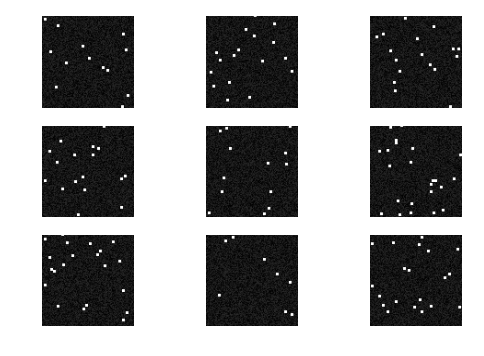

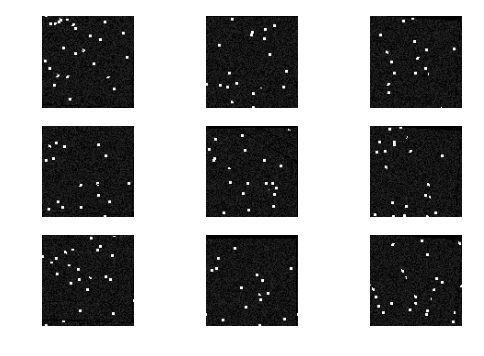

	Initial Error:  9.9886164719e+13


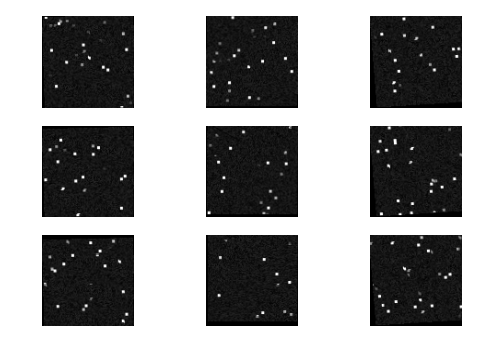

	Final Pipeline Error:  3.0842640895e+13
	Final Random Error:  1.00850820697e+14
	Pipeline Reduction Ratio:  0.691222092851
	Random Reduction Ratio:  -0.00965755347891





Executing Test:  13
[[  9.96214993e-01   5.11462694e-02   7.02833318e-02   2.86916263e-01]
 [ -5.09038629e-02   9.98689827e-01  -5.23691112e-03   1.86559292e+00]
 [ -7.04590970e-02   1.63939629e-03   9.97513322e-01   2.47553033e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


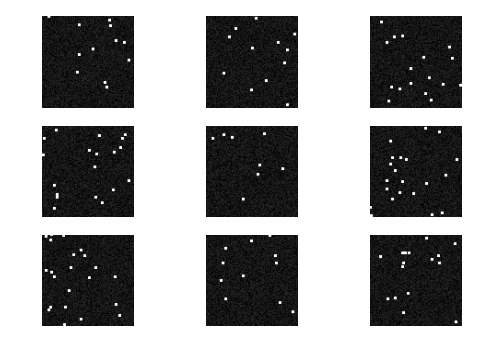

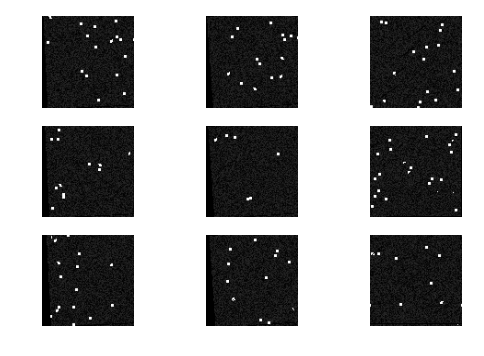

	Initial Error:  9.50819057287e+13


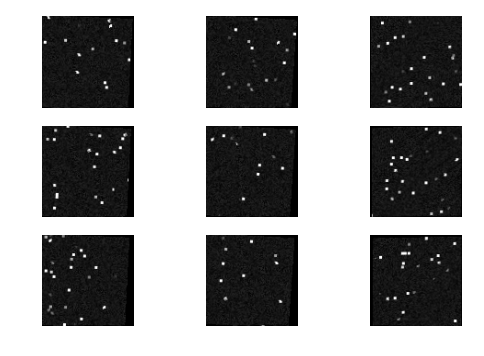

	Final Pipeline Error:  2.80741751313e+13
	Final Random Error:  9.61227002242e+13
	Pipeline Reduction Ratio:  0.704736932688
	Random Reduction Ratio:  -0.0109462940138





Executing Test:  14
[[ 0.99986353  0.01312611  0.01003118  2.36049424]
 [-0.01334598  0.99966503  0.02217472  1.04893569]
 [-0.00973675 -0.02230557  0.99970378  1.52589143]
 [ 0.          0.          0.          1.        ]]


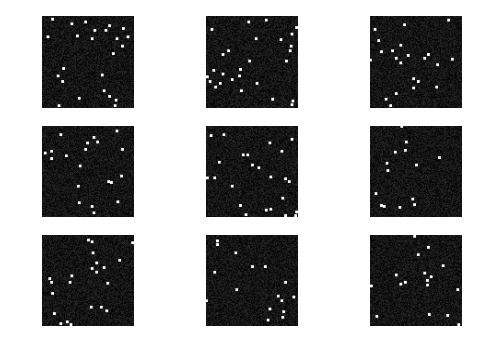

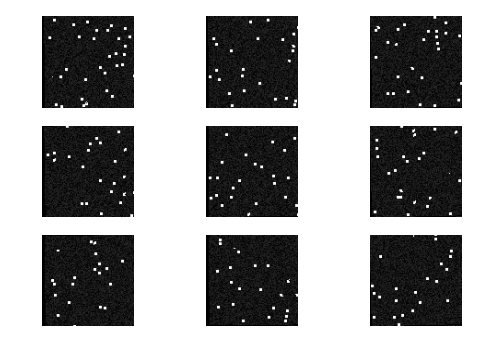

	Initial Error:  1.19218811813e+14


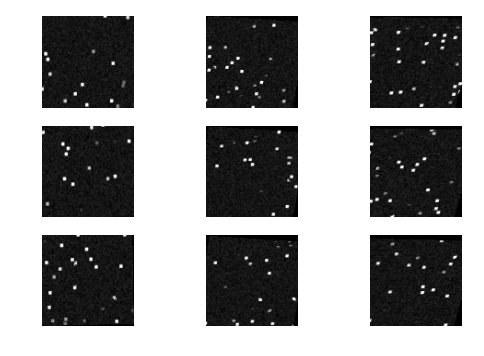

	Final Pipeline Error:  1.01358300258e+14
	Final Random Error:  1.20696996074e+14
	Pipeline Reduction Ratio:  0.149812863286
	Random Reduction Ratio:  -0.0123989179075





Executing Test:  15
[[  9.99129595e-01   4.17033373e-02   9.40084765e-04   1.47595364e-01]
 [ -4.15851811e-02   9.97562086e-01  -5.60406820e-02   2.02607248e+00]
 [ -3.27487639e-03   5.59528104e-02   9.98428044e-01  -7.13728846e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


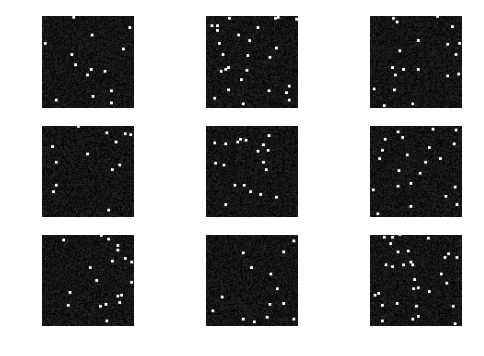

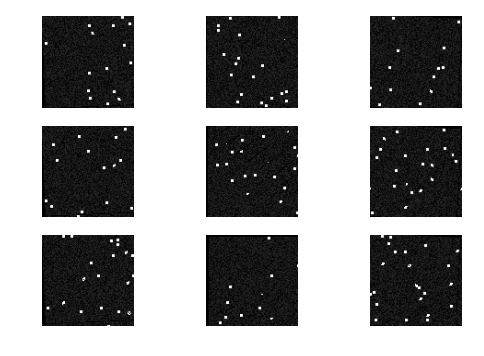

	Initial Error:  1.01607427714e+14


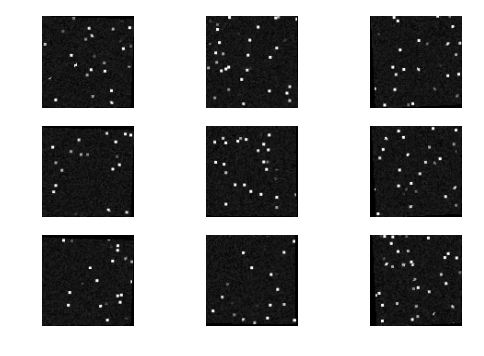

	Final Pipeline Error:  2.62470055091e+13
	Final Random Error:  1.08099316443e+14
	Pipeline Reduction Ratio:  0.74168221655
	Random Reduction Ratio:  -0.0638918716402





Executing Test:  16
[[ 0.99924818  0.0032177   0.03863581 -2.21439247]
 [-0.00385342  0.99985823  0.01639102  0.41024369]
 [-0.0385776  -0.01652757  0.99911892 -2.31186591]
 [ 0.          0.          0.          1.        ]]


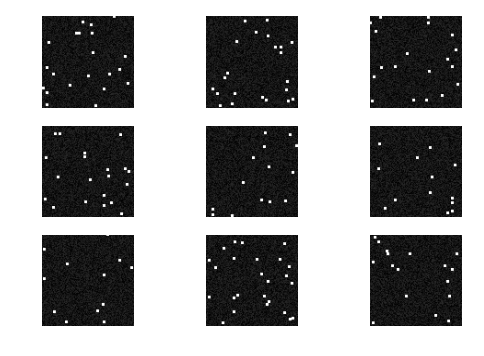

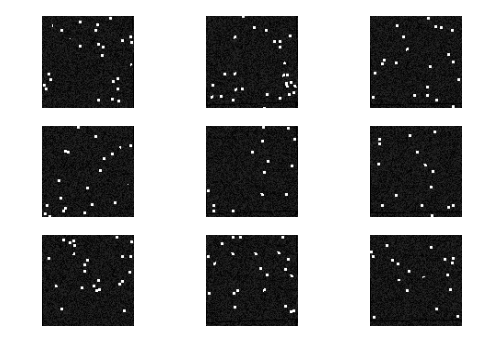

	Initial Error:  1.20455194763e+14


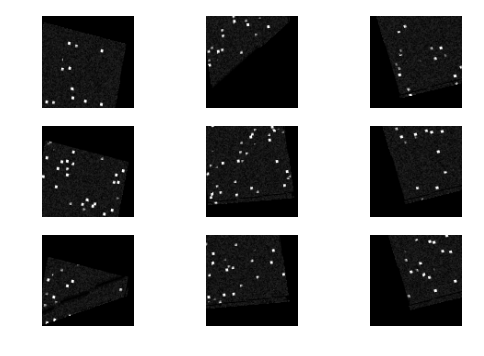

	Final Pipeline Error:  9.80032683451e+13
	Final Random Error:  1.1933762731e+14
	Pipeline Reduction Ratio:  0.186392346652
	Random Reduction Ratio:  0.00927786847156





Executing Test:  17
[[ 0.99934039  0.03489236  0.01006514  2.08174735]
 [-0.03428762  0.99789559 -0.05503402  1.06027483]
 [-0.01196422  0.05465261  0.99843375  0.34889319]
 [ 0.          0.          0.          1.        ]]


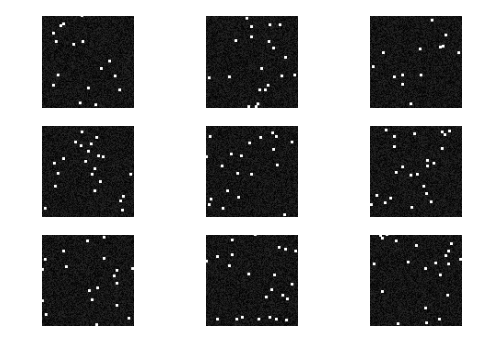

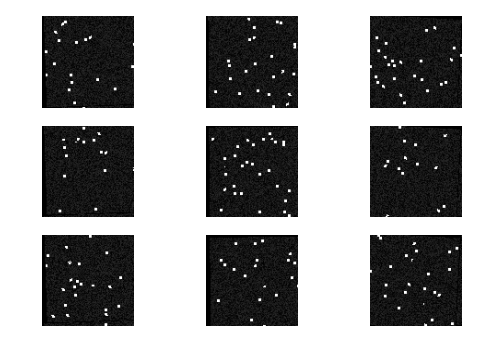

	Initial Error:  1.16811457329e+14


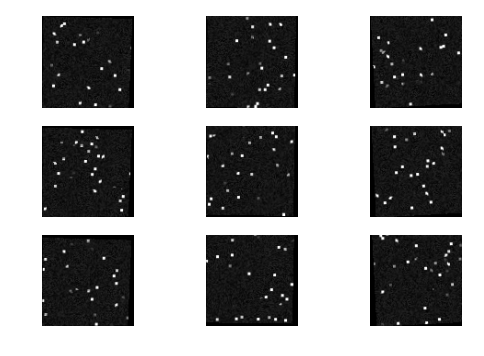

	Final Pipeline Error:  2.71505672492e+13
	Final Random Error:  1.16732891603e+14
	Pipeline Reduction Ratio:  0.767569313233
	Random Reduction Ratio:  0.000672585782677





Executing Test:  18
[[ 0.99688314  0.0292906  -0.07325337 -2.44677668]
 [-0.0302031   0.999479   -0.01137994 -0.54683245]
 [ 0.07288188  0.01355695  0.99724843  2.24903111]
 [ 0.          0.          0.          1.        ]]


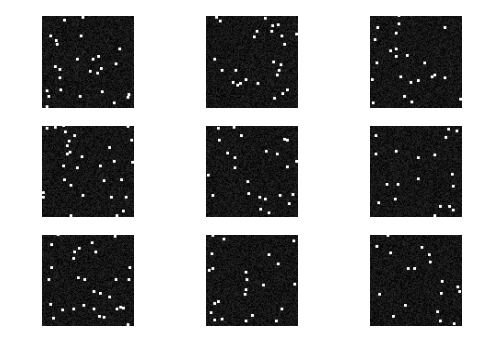

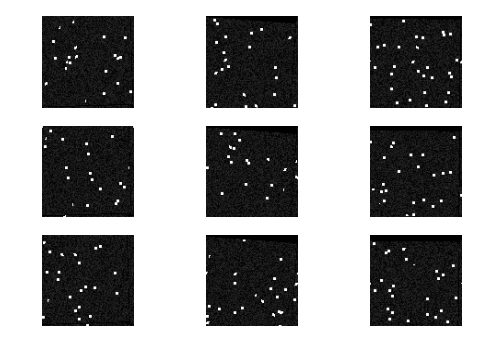

	Initial Error:  1.36837229308e+14


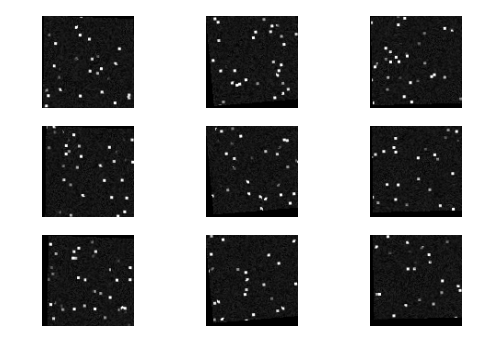

	Final Pipeline Error:  5.14067868851e+13
	Final Random Error:  1.35905267512e+14
	Pipeline Reduction Ratio:  0.624321632753
	Random Reduction Ratio:  0.00681073272935





Executing Test:  19
[[ 0.9982496  -0.01052542  0.05819754 -0.00603639]
 [ 0.00686615  0.99800736  0.06272298 -2.38566602]
 [-0.05874176 -0.06221359  0.99633271  1.84273997]
 [ 0.          0.          0.          1.        ]]


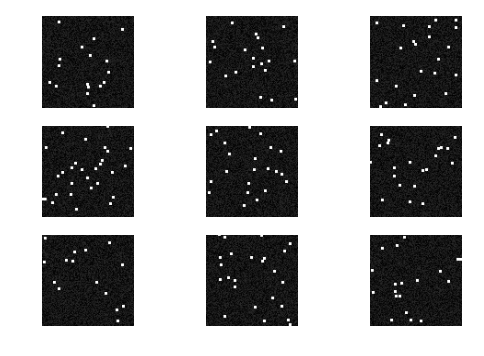

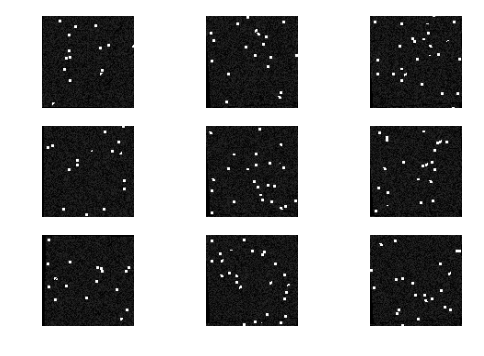

	Initial Error:  1.22112514678e+14


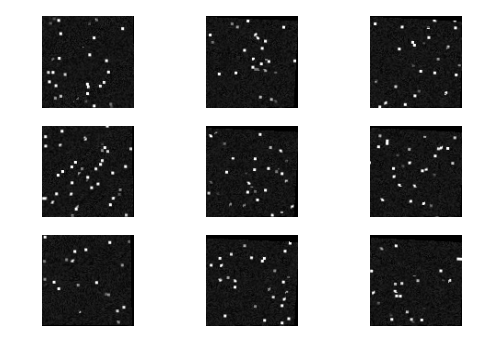

	Final Pipeline Error:  4.10385548225e+13
	Final Random Error:  1.1274284768e+14
	Pipeline Reduction Ratio:  0.663928345667
	Random Reduction Ratio:  0.0767297850072





Executing Test:  20
[[ 0.99724877 -0.06426549  0.0369436  -0.02944063]
 [ 0.06187574  0.99612202  0.06254849 -0.92164659]
 [-0.04082005 -0.06009049  0.99735794 -0.29477372]
 [ 0.          0.          0.          1.        ]]


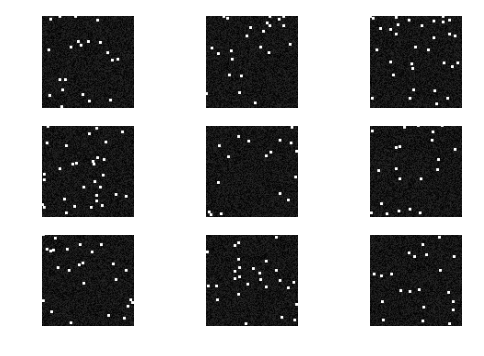

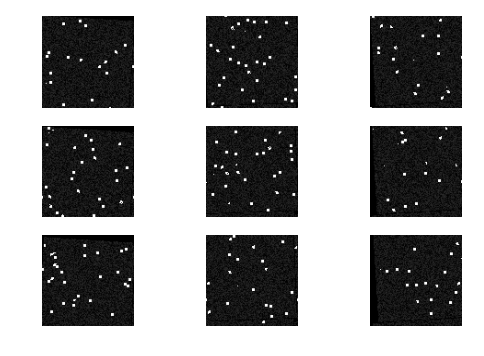

	Initial Error:  1.39911634367e+14


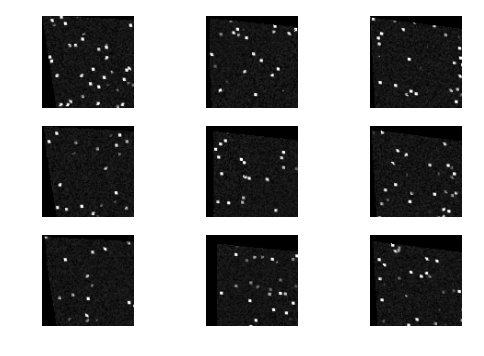

	Final Pipeline Error:  1.15523645205e+14
	Final Random Error:  1.39756803955e+14
	Pipeline Reduction Ratio:  0.174309944073
	Random Reduction Ratio:  0.00110662999829





Average Error Reduction Ratio:
	Pipeline:  0.490271058383
	Random:  0.0015678681932

Error Reduction Ratio Variance
	Pipeline:  0.0695132826357
	Random:  0.00120149500146


In [52]:
pipelineDat = []
randDat = []
for i in range(20):
    print '\nExecuting Test: ', i+1
    
    #generate an display data
    itkVolume, rigidVolume, curTransform = generateTestVolume()
    print curTransform
    ndreg.imgShow(itkVolume, vmax=60000)
    ndreg.imgShow(rigidVolume, vmax=60000)
    
    #calculate initial error
    initialErr = np.sum((itk.GetArrayFromImage(itkVolume)-itk.GetArrayFromImage(rigidVolume))**2)
    print '\tInitial Error: ', initialErr
    
    #perform transform
    transform = register(rigidVolume, itkVolume)
    resultVolume = ndreg.imgApplyAffine(rigidVolume, transform, size=itkVolume.GetSize(), spacing=itkVolume.GetSpacing())
    ndreg.imgShow(resultVolume, vmax=60000)
    #perform random transform
    randMatrix = applyRigid(itk.GetArrayFromImage(rigidVolume), getTransform())

    
    #calculate final error
    finalPipeErr = np.sum((itk.GetArrayFromImage(itkVolume)-itk.GetArrayFromImage(resultVolume))**2)
    finalRandErr = np.sum((itk.GetArrayFromImage(itkVolume)-randMatrix)**2)
    print '\tFinal Pipeline Error: ', finalPipeErr
    print '\tFinal Random Error: ', finalRandErr

    #get the reduction in error
    pipeRatio = (initialErr - finalPipeErr)/initialErr 
    randRatio = (initialErr - finalRandErr)/initialErr 
    pipelineDat.append(pipeRatio)
    randDat.append(randRatio)
    
    print '\tPipeline Reduction Ratio: ', pipeRatio
    print '\tRandom Reduction Ratio: ', randRatio
    print '\n\n\n'
    
print '\nAverage Error Reduction Ratio:'
print '\tPipeline: ', np.average(pipelineDat)
print '\tRandom: ', np.average(randDat)

print '\nError Reduction Ratio Variance'
print '\tPipeline: ', np.var(pipelineDat)
print '\tRandom: ', np.var(randDat)

    


#### 3. Analyze Results
There is an interestingly high variance in the NDReg pipeline's performance. I graphed the reduction ratio in a histogram below to demonstrate this observation.

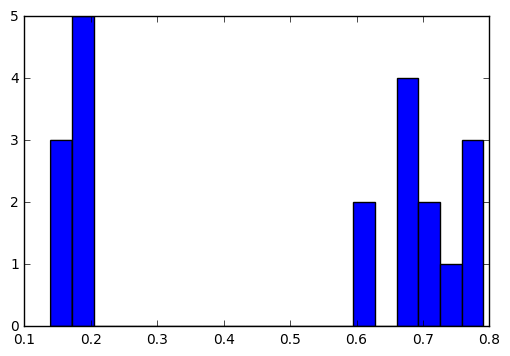

In [53]:
import matplotlib.pyplot as plt
plt.hist(pipelineDat, 20)
plt.show()

There is an obvious bimodal tendency to the distribution of these results. I am not yet sure what may be causing these highly variant results, but I will continue to investigate. I intend to show these to Kwame on Tuesday during our meeting in hope that he can shed some light on what the cause may be.

In terms of performance, the algorithm does perform far better than random, with a mean error reduction rate of 49% vs the .15% error reduction rate of the random algorithm. However, this error reduction rate is substantially skiewed by the 8 extremely low scores in the test results. Again, it is my 